<h1 style="text-align: center">Twitter Sentiment Analysis</h1>

#### First install required packages (Make sure you have `pip` installed)

In [ ]:
! pip install --user scipy wordcloud nltk seaborn textblob

#### Import the packages

In [ ]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
nltk.download('wordnet')   # for Lemmatization

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###### The dataset is not in "UTF-8" encoding

In [ ]:
total_data = pd.read_csv("dataset/train.csv", encoding="ISO-8859-1")

##### Import [Contractions](https://stackoverflow.com/a/19794953/8141330)

In [ ]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

###### Setting Pandas DataFrame to show non-truncated table

In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


##### Printing the dataset

In [ ]:
total_data

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T
...,...,...,...
60005,60017,0,@bellesimple2005 belle i miss you soo much char. drama pod. tinuod bitao!
60006,60018,0,@Belleslife Im spewing Poh got out she was my favorite
60007,60019,0,@belletragique I wish we would hang out like we used to.
60008,60020,0,@belletrist9 aaawwwww *hug* hopefully the experiment turns out better.. asap! *SNAP*


##### Taking column names into variables

In [ ]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]
tweet, sentiment

('SentimentText', 'Sentiment')

In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60010 entries, 0 to 60009
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ItemID         60010 non-null  int64 
 1   Sentiment      60010 non-null  int64 
 2   SentimentText  60010 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Tokenization**
* **Text Normalization[Lemmatization])**

##### Define a function which handles emoji classifications

In [ ]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


###### Define a function which will preprocess the tweets

In [ ]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;)
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space
    return tweet

##### Side by side comparison of new tweets vs old tweets

In [ ]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

##### Compariing unprocessed tweets with the processed one

In [ ]:
total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


### Tokenization

In [ ]:
tokenized_tweet = total_data['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [is, so, sad, for, my, apl, friend]                                                                                 
1    [missed, the, new, moon, trailer]                                                                                   
2    [omg, its, already]                                                                                                 
3    [omgaga, im, soo, im, gunna, cry, ve, been, at, this, dentist, since, was, suposed, just, get, crown, put, on, mins]
4    [think, mi, bf, is, cheating, on, me, t_t]                                                                          
Name: processed_tweet, dtype: object

### Lemmatization

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [is, so, sad, for, my, apl, friend]                                                                               
1    [missed, the, new, moon, trailer]                                                                                 
2    [omg, it, already]                                                                                                
3    [omgaga, im, soo, im, gunna, cry, ve, been, at, this, dentist, since, wa, suposed, just, get, crown, put, on, min]
4    [think, mi, bf, is, cheating, on, me, t_t]                                                                        
Name: processed_tweet, dtype: object

# 2) Most used words

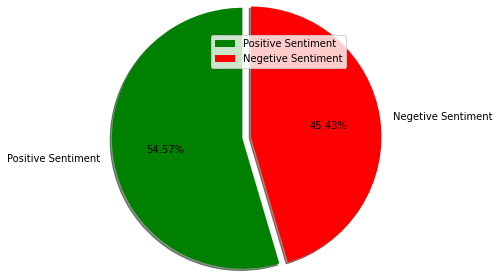

In [ ]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment']
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()]
colors = ['g', 'r']
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%')
plt.legend()
plt.show()

## 2.2) Most used positive words

<Figure size 3600x2400 with 0 Axes>

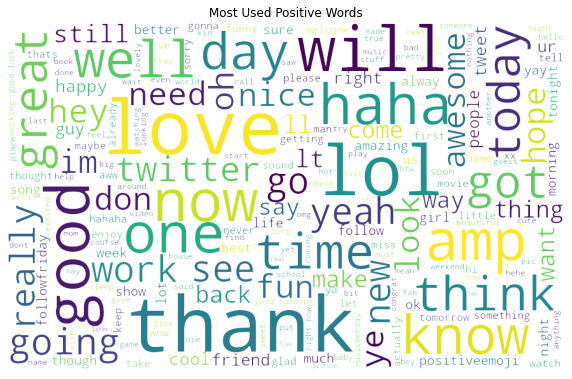

In [ ]:
positive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
plt.savefig('assets/positive_words.png')
plt.show()

## 2.3) Most used negetive words

<Figure size 3600x2400 with 0 Axes>

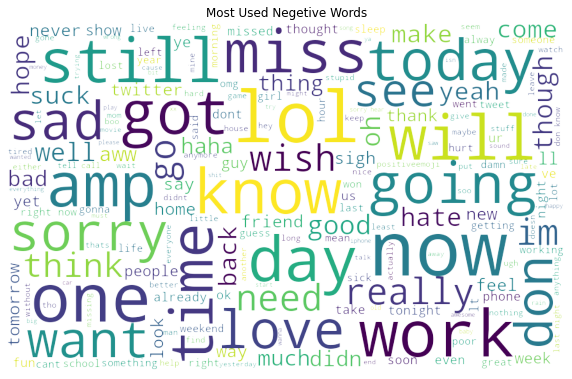

In [ ]:
negetive_words =' '.join([text for text in total_data['processed_tweet'][total_data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negetive Words")
plt.show()

### See the word `lol`. It is used both in positive and negetive(sarcastic) sentiments. We still can't classify sarcasm.

# 3) Feature extraction (vectorization)

### Tf-Idf vectorizer

*TF-IDF (stands for Term-Frequency-Inverse-Document Frequency)* weights down the common words occuring in almost all the documents and give more importance to the words that appear in a subset of documents. *TF-IDF* works by penalising these common words by assigning them lower weights while giving importance to some rare words in a particular document. ***Rare terms are more informative than frequent terms.***

![](assets/tfidf.png)

<br/>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
final_vectorized_data = tf_idf_vectorizer.fit_transform(total_data['processed_tweet'])

final_vectorized_data

<60010x785090 sparse matrix of type '<class 'numpy.float64'>'
	with 1839514 stored elements in Compressed Sparse Row format>

# 4) Splitting

##### Splitting train data to test accuracy

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)

In [ ]:
print(X_train)

  (0, 720049)	0.1896827406495132
  (0, 512227)	0.1896827406495132
  (0, 327279)	0.1896827406495132
  (0, 355832)	0.1896827406495132
  (0, 197262)	0.1896827406495132
  (0, 223563)	0.1896827406495132
  (0, 704058)	0.1896827406495132
  (0, 618758)	0.1896827406495132
  (0, 548080)	0.1896827406495132
  (0, 261652)	0.1896827406495132
  (0, 340028)	0.1896827406495132
  (0, 348826)	0.1896827406495132
  (0, 726438)	0.1896827406495132
  (0, 720048)	0.1896827406495132
  (0, 512226)	0.1896827406495132
  (0, 355831)	0.1896827406495132
  (0, 197261)	0.1896827406495132
  (0, 223562)	0.1896827406495132
  (0, 704057)	0.1896827406495132
  (0, 261651)	0.1896827406495132
  (0, 348823)	0.15192289770277057
  (0, 223559)	0.16445556826911728
  (0, 340023)	0.1610898144608572
  (0, 618754)	0.15282974140246158
  (0, 548071)	0.16268840662152903
  :	:
  (48007, 543869)	0.21562354861028377
  (48007, 329542)	0.20979121101014184
  (48007, 147471)	0.2423877722764553
  (48007, 280427)	0.18777472331370332
  (48007, 2803

In [ ]:
print(X_test)

  (0, 688774)	0.36065979619099636
  (0, 439594)	0.36065979619099636
  (0, 384383)	0.36065979619099636
  (0, 209946)	0.24727614691549846
  (0, 688773)	0.36065979619099636
  (0, 439593)	0.36065979619099636
  (0, 384382)	0.36065979619099636
  (0, 688748)	0.2628164818545309
  (0, 438787)	0.16765254518618253
  (0, 384130)	0.18614354403417316
  (0, 451983)	0.1283832580847294
  (0, 206596)	0.10044907491653937
  (1, 305787)	0.2620050580963078
  (1, 367978)	0.2620050580963078
  (1, 29703)	0.2620050580963078
  (1, 752813)	0.2620050580963078
  (1, 581009)	0.2620050580963078
  (1, 584934)	0.2620050580963078
  (1, 305786)	0.2620050580963078
  (1, 581008)	0.2620050580963078
  (1, 165187)	0.2365528947216014
  (1, 165185)	0.22471831270737624
  (1, 367917)	0.1728065421264372
  (1, 752812)	0.19092576528961788
  (1, 673435)	0.2526114218874654
  :	:
  (11999, 206596)	0.05441938560424956
  (12000, 335496)	0.49060230844580155
  (12000, 260949)	0.4253538363760567
  (12000, 335495)	0.49060230844580155
  (1200

In [ ]:
print(y_train)

30221    0
50666    0
16372    1
30900    0
58186    1
        ..
47508    0
25015    0
9818     1
4041     0
56523    0
Name: Sentiment, Length: 48008, dtype: int64


In [ ]:
print(y_test)

294      1
24938    0
57355    1
11387    1
4198     1
        ..
29414    1
12882    0
29614    0
89       1
12427    1
Name: Sentiment, Length: 12002, dtype: int64


##### Printing splitted dataset sizes

In [ ]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (48008, 785090)
X_test_shape :  (12002, 785090)
y_train_shape :  (48008,)
y_test_shape :  (12002,)


# 5) Train and predict

### 5.1) Naive_bayes

#### Bayes theorem :
![](assets/bayes_formula.jpg)

#### There are some popular classifiers under Naive Bayes
* **Bernoulli Naive Bayes**
* **Gaussian Naive Bayes classifier**
* **Multinomial Naive Bayes**

#### We will use Multinomial Naive Bayes classifier as it shows better accuracy than others

In [ ]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train)
predicted_naive = model_naive.predict(X_test)

In [ ]:
print(X_test)
print(predicted_naive)

  (0, 688774)	0.36065979619099636
  (0, 439594)	0.36065979619099636
  (0, 384383)	0.36065979619099636
  (0, 209946)	0.24727614691549846
  (0, 688773)	0.36065979619099636
  (0, 439593)	0.36065979619099636
  (0, 384382)	0.36065979619099636
  (0, 688748)	0.2628164818545309
  (0, 438787)	0.16765254518618253
  (0, 384130)	0.18614354403417316
  (0, 451983)	0.1283832580847294
  (0, 206596)	0.10044907491653937
  (1, 305787)	0.2620050580963078
  (1, 367978)	0.2620050580963078
  (1, 29703)	0.2620050580963078
  (1, 752813)	0.2620050580963078
  (1, 581009)	0.2620050580963078
  (1, 584934)	0.2620050580963078
  (1, 305786)	0.2620050580963078
  (1, 581008)	0.2620050580963078
  (1, 165187)	0.2365528947216014
  (1, 165185)	0.22471831270737624
  (1, 367917)	0.1728065421264372
  (1, 752812)	0.19092576528961788
  (1, 673435)	0.2526114218874654
  :	:
  (11999, 206596)	0.05441938560424956
  (12000, 335496)	0.49060230844580155
  (12000, 260949)	0.4253538363760567
  (12000, 335495)	0.49060230844580155
  (1200

##### Print Confusion matrix

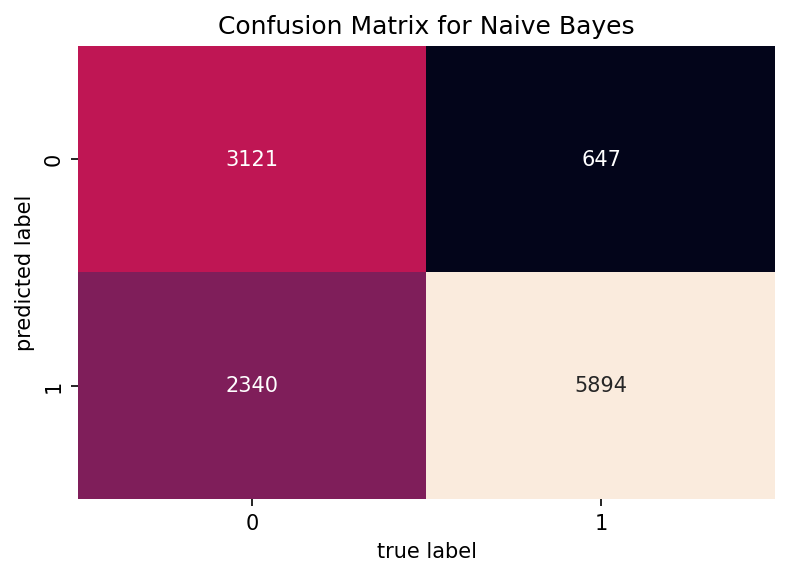

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Find out accuracy of our prediction

In [ ]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)

Accuracy with Naive-bayes:  0.7511248125312447


# 6) Precision, Recall, and Accuracy

##### Precision, recall, and accuracy are standard metrics used to evaluate the performance of a classifier.

* Precision measures how many texts were predicted correctly as belonging to a given category out of all of the texts that were predicted (correctly and incorrectly) as belonging to the category.

* Recall measures how many texts were predicted correctly as belonging to a given category out of all the texts that should have been predicted as belonging to the category. We also know that the more data we feed our classifiers with, the better recall will be.

* Accuracy measures how many texts were predicted correctly (both as belonging to a category and not belonging to the category) out of all of the texts in the corpus.

##### Most frequently, precision and recall are used to measure performance since accuracy alone does not say much about how good or bad a classifier is.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.83      0.57      0.68      5461
           1       0.72      0.90      0.80      6541

    accuracy                           0.75     12002
   macro avg       0.77      0.74      0.74     12002
weighted avg       0.77      0.75      0.74     12002



### Drawing ROC curve

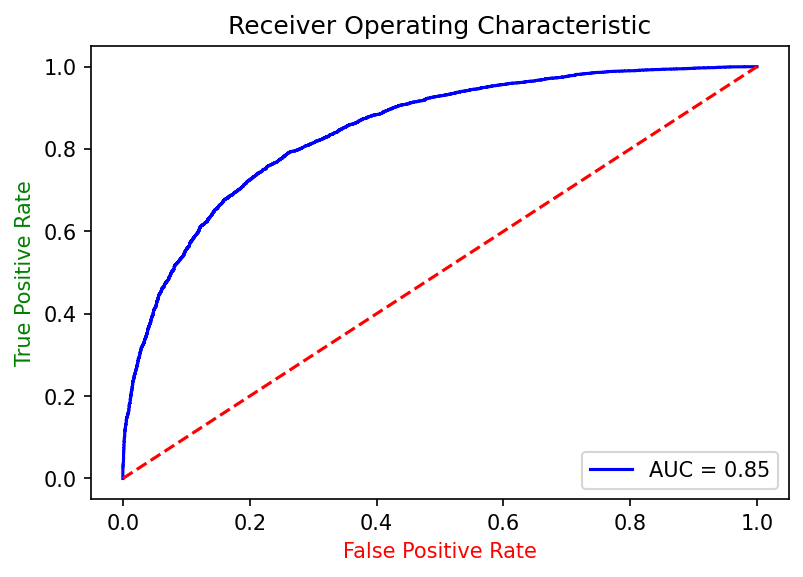

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=150)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')

plt.show()